# Part I - Setup & Dataset Prep
-------------------------------

## 1. Setup


### 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [46]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [47]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT.

In [48]:
!pip install transformers

## 2. Retrieve & Inspect Dataset




This notebook will download and tokenize a text dataset comprised of comments on Wikipedia which contain "attacks" on other users (plus counter-examples).

We'll use `pandas` to parse the dataset `.tsv` file, and we'll use the gensim function `gensim.utils.simple_preprocess` for tokenizing the sentences.

We'll save the processed dataset back to disk for use in other notebooks.

**About the Dataset**

* wikimedia page describing the dataset [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Personal_Attacks/4054689).
* Dataset download page on figshare.com for the personal attack comments [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Personal_Attacks/4054689).
    * `attack_annotated_comments.tsv  -  ` contains the comment text and some properties.
    * `attack_annotations.tsv  -  ` contains the labels (whether the comment contains an attack).
* Example notebook (from the authors) for getting started with the dataset [here](https://github.com/ewulczyn/wiki-detox/blob/master/src/figshare/Wikipedia%20Talk%20Data%20-%20Getting%20Started.ipynb).

### 2.1. Download
--------------------------------------
Download the text.

In [49]:
import urllib
import os

# Create the data subdirectory if not there.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

files = [
    ('./data/attack_annotated_comments.tsv',  'https://ndownloader.figshare.com/files/7554634'),
    ('./data/attack_annotations.tsv',         'https://ndownloader.figshare.com/files/7554637')
]

for (filename, url) in files:
    # Download download if we already have it!
    if not os.path.exists(filename):

        # Download the dataset.
        print('Downloading', filename)

        urllib.request.urlretrieve(url, filename)

        print('  DONE.')



### 2.2. Parse & Inspect
-------------------
We'll use `pandas` just to help us parse the tab-separated `.tsv` file.


In [50]:
import pandas as pd

print('Parsing the dataset .tsv file...')
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep = '\t')

print('    Done.')

Parsing the dataset .tsv file...
    Done.


Let's take a look at the first few rows of the table just to see what's in there.

In [51]:
# Display the first five rows of the table.
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


The dataset is split into 'train', 'test', and 'dev'--how big are each of these?

In [52]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [53]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


Label the comments.

In [54]:
# Label a comment as an atack if the majority of annoatators did so
# The comments are uniquely identified by their 'rev_id'. The annotations table
# has multiple rows for each comment because there were multiple labelers.
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# Join labels and comments
comments['attack'] = labels

In [55]:
# Remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

Divide the dataset into training and test comments.

In [56]:
# fit a simple text classifier
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

Display some of the comments labeled as containing an attack. Be prepared to see some terrible human behavior...

In [57]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

# Filter to just the "attack" comments.
attack_examples = train_comments.query('attack')['comment']

# Randomly choose some examples.
for i in range(10):
    j = random.choice(attack_examples.index)

    print('')
    print(wrapper.fill(attack_examples[j]))
    print('')



  I took my article down five years ago becuase people kept removing links and
fucking with it. Then someone else put on up and I said OK. then I saw all the
links had been removed and I fixed them. Now I have you neurotic shits fucking
with it. Leve it alone or take it the fuck down.   This isn't about cruise
ships, it's about women. I am constanlty under attack and I dont' need you
abetting that. Fuck off.


 And you removed it! You numbskull! I don't care what you say anymore, this is
my life! Go ahead with your own life, leave me alone! —


  == Excuse me... ==  no, fuck you.


  HOW MY TING VANDALISM ARE YOU DUMB ? I AM GOING TO BE FAMOUS THEN YOU WILL BE
SORRY!


  ==Then Assert Your Case; Please Do...==  You write:  :But that aside, in
reading the section above this one, you almost sound as if you wish to be
blocked.  ::I am not afraid, as you administrators appear to want us to be, in
FEAR. I have found you to be, and I'm not suprized, to be in Chomskyen, 'NAKED.'
::You are wi

What percentage of the comments are attacks?

In [58]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print('{:,} of {:,} comments are attacks ({:.2%})'.format(num_attacks, total_comments, num_attacks/total_comments))

13,590 of 115,864 comments are attacks (11.73%)


The classes are very imbalanced, so we have to be careful interpreting our accuracy...

In [59]:
prcnt_non_attack = 1 - (len(test_comments.query('attack')) / len(test_comments))

print('Always predicting "not attack" will yield {:.2%} accuracy on the test set.'.format(prcnt_non_attack))

Always predicting "not attack" will yield 88.11% accuracy on the test set.


## 3. BERT Input Length Limitation

BERT has a maximum input length of 512 tokens. In this section, we'll look at how this limitation affects us in practice, and some possible approaches for addressing it.

### 3.1. Examples of 512 Tokens

Let's look at an example comment which gets split into more than 512 tokens, so that we can get a sense for how much text fits within this limit.

First we'll need to load the BERT tokenizer.

In [60]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


The first comment in the training set happens to be longer than 512 tokens, and doesn't contain an attack (so we don't have to spend any more time than necessary looking at hateful garbage!).

As a side note on this benchmark, it's interesting to see that this comment is certainly argumentative, and the author is in conflict with another user, but it *does not* contain a personal attack.

In [61]:
# Retrieve the text of the first comment.
text = train_comments.iloc[0].comment

# Run the tokenizer to count up the number of tokens. The tokenizer will split
# the text into words, punctuation, and subwords as needed.
tokens = tokenizer.tokenize(text)

print('Comment 0 (not an attack) contains {:,} WordPiece tokens.'.format(len(tokens)))
print('\nOriginal comment text:\n')
print(wrapper.fill(text))


Comment 0 (not an attack) contains 591 WordPiece tokens.

Original comment text:

`- This is not ``creative``.  Those are the dictionary definitions of the terms
``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you
don't understand that, fine, legitimate criticism, I'll write up ``three man
cell`` and ``bounty hunter`` and then it will be easy to understand why
``ensured`` and ``insured`` are different - and why both differ from
``assured``.  The sentence you quote is absolutely neutral.  You just aren't
familiar with the underlying theory of strike-back (e.g. submarines as employed
in nuclear warfare) guiding the insurance, nor likely the three man cell
structure that kept the IRA from being broken by the British.  If that's my
fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or
``creative`` about it.  I'm tired of arguing with you.  Re: the other article,
``multi-party`` turns up plenty, and there is more use of ``mutually`` than
``

Let's see how this text looks broken into tokens. We'll separate the first 512 tokens from the balance, in order to see how much text we'd lose by truncating.

In [62]:
# Print out the list of tokens
print('==== First 512 tokens: ====\n')
print(wrapper.fill(str(' '.join(tokens[0:512]))))

print('')

print('\n==== Remaining {:,} tokens: ====\n'.format(len(tokens) - 512))
print(wrapper.fill(str(' '.join(tokens[512:]))))

==== First 512 tokens: ====

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and the

This comment contains a lot of punctuation (many quotes and some parentheses) which each end up as a separate token for BERT.

Out of curiosity, let's look at how many actual words and sentences this text contains versus tokens.

In [63]:
# First truncate the text to remove the last 79 tokens (which begin with the
# words "are made in").
last_char = text.find('are made in')

# Truncate the text to only what fits in the 512 tokens.
text = text[0:last_char]

# Estimate the number of words in the comment by splitting it on whitespace.
# First remove all double spaces.
text = text.replace('  ', ' ')
num_words = len(text.split(' '))

print('Comment contains ~{:,} words.'.format(num_words))

# Estimate the number of sentences by counting up the periods.
num_sens = text.count('. ')

print('Comment contains ~{:,} sentences.'.format(num_sens))

Comment contains ~330 words.
Comment contains ~20 sentences.


### 3.2. Strategies for Longer Text

Key points:
* There's no *obvious* solution, but we'll cover a number of ideas to try.
* Looking at the statistics of your dataset should help when choosing your strategy. We'll do this in section 3.3.

There was a [paper published](https://arxiv.org/pdf/1905.05583.pdf) recently that investigated this problem and experimented with a few approaches.  Check out section 5.3. specifically.

[![BERT Text Classification Paper](https://drive.google.com/uc?export=view&id=1d9p_Ks5RUtFdKr_Fv5Oaie4HywRS4Zzg)](https://drive.google.com/uc?export=view&id=1d9p_Ks5RUtFdKr_Fv5Oaie4HywRS4Zzg)




**Truncation**

The simplest approach is just to drop some of the tokens, and hope that the remaining text is enough to perform the task well.

You could drop tokens:
* From the beginning of the text.
* At the end of the text.
* In the middle of the text.

In the above paper, their experiments on the IMDb movie review dataset showed that keeping the first 128 tokens and the last 382 tokens performed best. (Note: This adds up to 510 tokens, leaving room for the special `[CLS]` and `[SEP]` tokens that we have to append to the beginning and the end of the text, respectively).

Perhaps this is because, when writing something like a movie review, we tend to put our high-level points in the introduction and conclusion?



**Chunking**

Another approach attempted by the authors (and also proposed in [this thread](https://github.com/google-research/bert/issues/650) in the BERT GitHub repo) would be to divide the text into 512-token chunks and generate embeddings for these chunks separately.

The authors of the paper combined the embeddings for the different chunks before performing the final classification. They tried several "pooling" strategies, such as averaging the embeddings together. None of these approaches outperformed the simple truncation approach, however.

In the GitHub discussion above, the user suggested instead classifying the chunks separately and then averaging together the predictions.

Mariano Kamp, in a comment on my YouTube video, also made the insightful observation that these "chunking" approaches could be computationly expensive when dealing with lengthy documents.

I've included another Notebook in this tutorial which employs the chunking strategy, [Wikipedia Comments - Chunking Approach.ipynb](https://colab.research.google.com/drive/1A-Cq9OZZ6DcU2iy328DWGWlBWx96K5jo?usp=sharing).


** BERT Variants**


Various research groups have also tried modifying BERT's architecture to enable it to support longer input sequences.

Two of the most practical examples are *Longformer* (from Allen AI) and *BigBird* (from Google), which can handle up to 8x longer sequences than BERT. These two models are very similar, with BigBird being the slightly more recent model intended to improve over Longformer.

BigBird largely retains BERT's architecture, but uses a technique called "Sparse Attention" to trade off accuracy for longer sequence length.



### 3.3. Comment Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of comment lenghts.

To do this, our first step is to tokenize all of the comments in the training set.

**Tokenize All Comments**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of comment lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every comment that's longer than 512 tokens. We'll just have to ignore those for now!

In [64]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in train_comments.comment:

    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
  Read 0 comments.
  Read 20,000 comments.
  Read 40,000 comments.
  Read 60,000 comments.
DONE.
    69,526 comments


Before we continue, let's also retrieve the comment labels, and check out the class distribution for this dataset.

In [65]:
# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
labels = train_comments.attack.to_numpy().astype(int)

print('{:>7,} positive (contains attack)'.format(np.sum(labels)))
print('{:>7,} negative (not an attack)'.format(len(labels) - np.sum(labels)))

  8,079 positive (contains attack)
 61,447 negative (not an attack)


Let's grab some quick statistics--what are the min, max and median comment lenghts?

In [66]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 2 tokens
   Max length: 9,861 tokens
Median length: 52.0 tokens


To further analyze it, let's plot the distribution. To keep the scale of the x-axis reasonable, *we'll clip the lengths to 512.*


<ipython-input-67-6e3d5755b4cf>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths, kde=False, rug=False)


Text(0, 0.5, '# of Comments')

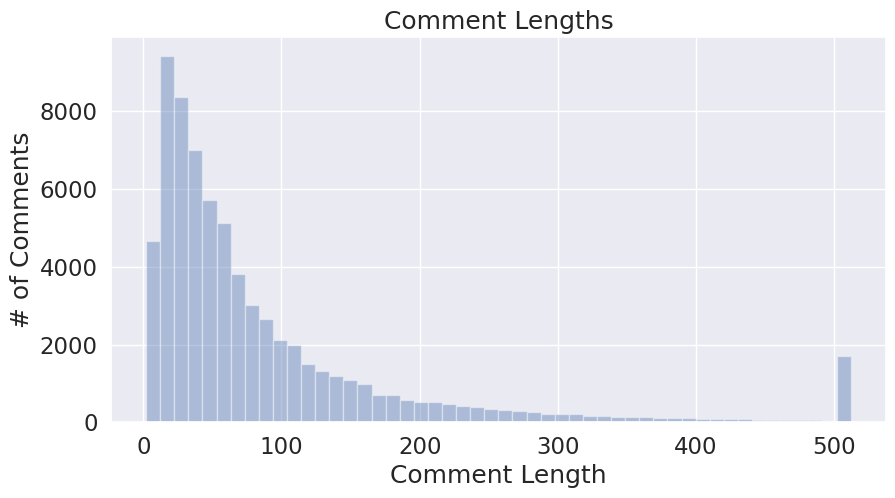

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')


Clearly most comments are "short", and there's a long tail of longer comments.

Just how many of the examples run into the 512-token limit?

In [68]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

1,668 of 69,526 sentences (2.4%) in the training set are longer than 512 tokens.


And of those, how many contain personal attacks?

In [69]:
# Tally up how many of the truncated sentences are positive vs. negative examples.
num_pos = 0
num_neg = 0

# Iterate through the comment lengths...
for i, l in enumerate(lengths):

    # If the sentence was truncated...
    if l == 512:

        # Tally up whether it contains a personal attack or not.
        if labels[i] == 1:
            num_pos += 1
        else:
            num_neg += 1

# Report the total.
print('{:,} ({:.1%}) of the truncated examples contain a personal attack.'.format(num_pos, num_pos / (num_neg + num_pos)))

202 (12.1%) of the truncated examples contain a personal attack.


Interesting! I think this makes sense, given that you wouldn't typically expect for hateful comments to be long and well-reasoned :).

### 3.4. Pad & Truncate the Comments

I think it seems safe to truncate our comments to 512 tokens.

Not only that, but I think we can get away with an even shorter sequence length to speed things up. I've picked a max length of 128, since this is around the "elbow" of the distribution.

We can always try longer lengths later to see how much this improves our results.

In [70]:
# We'll borrow the `pad_sequences` utility function to do this
import keras
from keras.utils import pad_sequences

# Set the required sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


**Attention Masks**

The attention mask simply makes it explicit which tokens are actual words versus which are padding.

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [71]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

### 3.5. Final Data Prep


We a few small data preparation steps to complete before we can move on to training and test.

(1) Divide up our training set to use 90% for training and 10% for validation.

In [72]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

(2) Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [73]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

(3) We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [74]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Part II - BERT Fine-Tuning

## 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

### 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [75]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [76]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [77]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 4.3. Training Loop

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set.

Define a helper function for calculating accuracy.

In [78]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [79]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,956.    Elapsed: 0:01:02.
  Batch   200  of  1,956.    Elapsed: 0:02:03.
  Batch   300  of  1,956.    Elapsed: 0:03:05.
  Batch   400  of  1,956.    Elapsed: 0:04:06.
  Batch   500  of  1,956.    Elapsed: 0:05:08.
  Batch   600  of  1,956.    Elapsed: 0:06:09.
  Batch   700  of  1,956.    Elapsed: 0:07:11.
  Batch   800  of  1,956.    Elapsed: 0:08:12.
  Batch   900  of  1,956.    Elapsed: 0:09:14.
  Batch 1,000  of  1,956.    Elapsed: 0:10:15.
  Batch 1,100  of  1,956.    Elapsed: 0:11:17.
  Batch 1,200  of  1,956.    Elapsed: 0:12:18.
  Batch 1,300  of  1,956.    Elapsed: 0:13:19.
  Batch 1,400  of  1,956.    Elapsed: 0:14:21.
  Batch 1,500  of  1,956.    Elapsed: 0:15:22.
  Batch 1,600  of  1,956.    Elapsed: 0:16:24.
  Batch 1,700  of  1,956.    Elapsed: 0:17:25.
  Batch 1,800  of  1,956.    Elapsed: 0:18:27.
  Batch 1,900  of  1,956.    Elapsed: 0:19:28.

  Average training loss: 0.14
  Training epcoh took: 0:20:02

R

Let's take a look at our training loss over all batches:

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [82]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in test_comments.comment:

    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
print('{:>10,} negative (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN,
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask)

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


DONE.

    23,178 test comments
     2,756 positive (contains attack)
    20,422 negative (not an attack)


### 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [83]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict
for (step, batch) in enumerate(test_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 23,178 test sentences...
  Batch   100  of    725.    Elapsed: 0:00:21.
  Batch   200  of    725.    Elapsed: 0:00:43.
  Batch   300  of    725.    Elapsed: 0:01:03.
  Batch   400  of    725.    Elapsed: 0:01:24.
  Batch   500  of    725.    Elapsed: 0:01:44.
  Batch   600  of    725.    Elapsed: 0:02:05.
  Batch   700  of    725.    Elapsed: 0:02:26.
    DONE.


In [84]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

Let's peek at the model's outputs for the first 10 test samples, along with the correct labels for each.

In [85]:
predictions[0:10]

array([[ 4.3049827, -4.493239 ],
       [ 4.4589667, -4.5689535],
       [ 4.497001 , -4.2439427],
       [ 4.4638085, -4.784724 ],
       [ 4.387356 , -4.556461 ],
       [ 4.665942 , -4.629351 ],
       [ 4.3023086, -4.6506977],
       [ 4.3759446, -4.056517 ],
       [ 4.6458726, -4.687939 ],
       [ 4.6696963, -4.7380066]], dtype=float32)

In [86]:
true_labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

These first ten examples all look correct (high confidence for label 0 and low confidence for label 1)! Let's see how we did on the full test set.

The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

*ROC AUC*

To illustrate the purpose of this metric, let's say that you were going to deploy this comment classifier on your website to automatically flag bad comments. In order to do that, you would have to make a decision about how confident you needed the classifier to be before flagging a comment as a personal attack.
* If it was critical that no bad comments be missed, then you might choose to set a fairly low threshold, and then have a human review what the classifier flags. This would help ensure that bad comments would be caught, but at the cost of getting more false positives that the moderator would have to deal with.
* If it wasn't critical to catch them all, and you wanted as few as possible to manually review, then you might you set a higher threshold so that you don't have as many flagged comments to review (at the risk of missing some attacks).

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [87]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.974


This is a great score!



## 6. Save Trained Model


### 6.1. Saving to Disk

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [88]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

### 6.2. Backing Up to Google Drive

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [89]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
gdrive_path = "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Part III - Semantic Similarity

In Part III, we'll walk through an example of using BERT to measure the "semantic similarity" of two pieces of text. "Semantic similarity" refers to how close in meaning the pieces of text are.

As a demonstration of this capability, we'll implement code to compare an arbitrary piece of input text (it could be from the dataset or one we supply ourselves) with all of the comments in the dataset and return the comments that are most similar in meaning to the input text.

## 7. Vectorize Comments

In this section, we will use our fine-tuned BERT model to extract sentence embeddings for all of the training comments.

To create these embeddings, we'll simply run the comments through the model the same way we did for training, but we'll take the embedding corresponding to the `[CLS]` token from the final BERT Transformer layer. It's the blue rectangle at the top left of the following illustration:

[![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)


### 7.1. Modifying Our Model to Output Embeddings

**Load from Google Drive**

If you need to restore your model from Google Drive, the following two cells demonstrate how to do this.

In [91]:
model.output_hidden_states = True

In [92]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# Copy the model files back from Google Drive to the Colab instance.
!cp -r "./drive/My Drive/BERT Document Classification Tutorial/model_save/" ./model_save/

Now we can load our model's weights, this time enabling the `output_hidden_states` flag.

This cell also demonstrates how to load the tokenizer from disk,though we haven't made any changes to it.

In [94]:
from transformers import BertForSequenceClassification, BertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states",
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### 7.2. text_to_embedding function

Here we'll define a function which can take an arbitrary piece of text and use our fine-tuned BERT model to compute a feature vector (aka "embedding") for the text.

Again, we'll be using the 768-feature vector corresponding to the special `[CLS]` token, taken from the final transformer layer.

Note that, for converting large amounts of text, we could improve our performance by modifying this function to accept multiple input texts at once. GPUs (and CPUs) are most efficient when they are given a *batch* of inputs to work on.

In [96]:
import torch


def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 128

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.
                   )

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long",
                              truncating="post", padding="post")

    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks
    attn_mask = [int(i>0) for i in input_ids]

    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)

    # Telling the model not to build the backwards graph will make this
    # a little quicker.
    with torch.no_grad():

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids,
                                    token_type_ids = None,
                                    attention_mask = attn_mask,
                                    return_dict=False)

    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]

    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)


### 7.3. Vectorize Dataset

We'll go back to the original dataset here. It should still be in memory as a pandas dataframe named `comments`.

Let's start by vectorizing a single comment.

In [97]:
# Get the text from one of the comments.
input_text = comments.iloc[10].comment

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ",
                               width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Getting embedding for sentence:

       :Correct. Full biographical details will put down his birth details, etc.
    It is just a marker to me at the moment to detail the WR aspect. He
    certainly wasn't Belarus; as a geo-political entity it had no real existence
    at the time. I have put a tbc marker on this article for now.

Done. Embedding shape: (768,)


It's working! In order to perform similarity search against this comments dataset, we now need to vectorize *all* of the comments.

Define a small helper function for formatting elapsed times.


In [98]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Loop over all of the comments in the dataset, converting each one. Prints progress periodically.

In [99]:
import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(comments)

print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe...
for index, row in comments.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)

        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.comment)

    # Store the embeddings.
    embeddings.append(vec)

    row_num += 1


Generating sentence embeddings for all 115,864 comments...
  Comment   2,000  of  115,864.    Elapsed: 0:00:29. Remaining: 0:27:33
  Comment   4,000  of  115,864.    Elapsed: 0:00:58. Remaining: 0:27:11
  Comment   6,000  of  115,864.    Elapsed: 0:01:27. Remaining: 0:26:37
  Comment   8,000  of  115,864.    Elapsed: 0:01:55. Remaining: 0:25:55
  Comment  10,000  of  115,864.    Elapsed: 0:02:23. Remaining: 0:25:12
  Comment  12,000  of  115,864.    Elapsed: 0:02:51. Remaining: 0:24:37
  Comment  14,000  of  115,864.    Elapsed: 0:03:26. Remaining: 0:24:56
  Comment  16,000  of  115,864.    Elapsed: 0:03:53. Remaining: 0:24:16
  Comment  18,000  of  115,864.    Elapsed: 0:04:23. Remaining: 0:23:51
  Comment  20,000  of  115,864.    Elapsed: 0:05:00. Remaining: 0:23:57
  Comment  22,000  of  115,864.    Elapsed: 0:05:29. Remaining: 0:23:22
  Comment  24,000  of  115,864.    Elapsed: 0:05:58. Remaining: 0:22:51
  Comment  26,000  of  115,864.    Elapsed: 0:06:28. Remaining: 0:22:20
  Com

In [100]:
import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

(115864, 768)

In [101]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)

# Copy the embeddings to a directory in your Google Drive.
!cp -r ./model_save/embeddings.npy "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

Saving embeddings to: ./model_save/embeddings.npy


## 8. Semantic Similarity Search

Now that we have our comments all vectorized, we are ready to make them "searchable".

We do this using a technique called "k-Nearest Neighbor Search" or "k-NN". Simply put, we use a distance metric such as Euclidean distance, calculate that distance between our "query" vector and all of the vectors to be searched, then sort the distances to find the closest matches.

All of those distance calculations can make k-NN search computationally expensive and slow. There are a number of libraries out there for accelerating k-NN using carefully optimized code and / or approximation techniques.

I personally like the FAISS (Facebook AI Similarity Search) library, in part because it has a really excellent GPU implementation.

Using the GPU, we can perform "brute-force" k-NN search (meaning no approximation techniques which compromise on accuracy) on this dataset quickly.

### 8.1. k-NN with FAISS and GPU

First we'll need to install FAISS.

In [103]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.9 MB/s eta 0:00:00


To create a GPU index with FAISS, you first create it on the CPU, then copy it over.

A "Flat" index means that it's brute-force, with no approximation tricks.

In [104]:
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPUs.
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is divided across
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()

gpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))


Number of available GPUs: 1    Using: 1
Adding dataset to index...
Building index took 0.10 seconds


Now let's try taking one of the comments from the dataset, and searching for the most semantically similar comments.

In [105]:
# Comment number 4 is short and sweet.
print('==== Input Comment =====')
print('Comment #4:')
print(wrapper.fill(comments.iloc[4].comment))

# Let's find the 5 most similar comments.
D, I = gpu_index.search(vecs[4].reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')



==== Input Comment =====
Comment #4:
    This page will need disambiguation.

==== Top 5 Results ====
Comment #4:
L2 Distance: 0.00
    "This page will need disambiguation. "

Comment #39,578:
L2 Distance: 13.53
    "  This page needs to be expand.   "

Comment #2,872:
L2 Distance: 15.82
    "DISAMBIGUATION PAGE needed  "

Comment #100,779:
L2 Distance: 16.11
    " Description on image page is confusing about this.   "

Comment #8,612:
L2 Distance: 17.21
    "why can't i edit this page?"



Using our `text_to_embedding` function, we can also define new text to use as our query. Let's try writing a new sentence that's similar in meaning to comment #4, but uses different language. The word "disambiguate" means "remove uncertainty of meaning from", so I've written "The meaning of this page needs to be clarified."



In [106]:
query_text = "The meaning of this page needs to be clarified."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')




==== Top 5 Results ====
Comment #4:
L2 Distance: 10.88
    "This page will need disambiguation. "

Comment #39,578:
L2 Distance: 14.79
    "  This page needs to be expand.   "

Comment #84,926:
L2 Distance: 16.71
    "  == Serious redundancy issues ==  There is substantial replication of text
    in this article.   "

Comment #48,854:
L2 Distance: 17.53
    "This page's history is completely not neutral It needs to be revamped."

Comment #101,805:
L2 Distance: 18.93
    "I need help to improve this page."



The results look pretty good!

Let's try another query, this time with a different intent.

In [107]:
query_text = "This article really needs more citations."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')




==== Top 5 Results ====
Comment #4:
L2 Distance: 14.10
    "This page will need disambiguation. "

Comment #101,805:
L2 Distance: 15.65
    "I need help to improve this page."

Comment #19,950:
L2 Distance: 17.86
    "  ==Expand== please expand this article. "

Comment #84,926:
L2 Distance: 18.31
    "  == Serious redundancy issues ==  There is substantial replication of text
    in this article.   "

Comment #102,270:
L2 Distance: 19.17
    " ::::No.  The comments are completely relevant to this article."

